<div align="center"><h3>HW1</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

In [1]:
import numpy as np
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Configuration Parameter

In [2]:
SAVE_CONTENTS = True

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def sign(X, offset=0):
    return np.heaviside(X - offset, 1) * 2 -1

# Question 1

Generating linearly separable dataset

In [5]:
mean1 = np.array([8, 8])
mean2 = np.array([0, 0])
cov = cov1 = cov2 = np.identity(2)
dist1 = np.random.multivariate_normal(mean1, cov1, size=5000)
dist2 = np.random.multivariate_normal(mean2, cov2, size=5000)
X = np.concatenate((dist1, dist2), axis=0)
y = np.array([1 if x in dist1 else -1 for x in X])

In [6]:
# Check if linearly separable
svm = SVC(kernel='linear', C=100)
svm.fit(X, y)
y_predicted = svm.predict(X)
acc = accuracy_score(y, y_predicted)
print(acc)

1.0


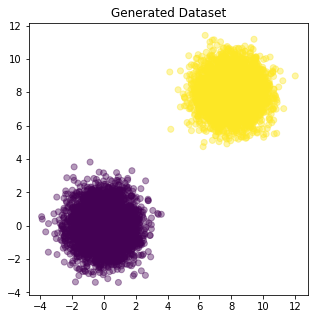

In [7]:
fig = plt.figure(figsize=(5,5))
plt.title('Generated Dataset')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.4)
if SAVE_CONTENTS:
    plt.savefig('images/dataset.png')

# Question 2

Adaline implementation

In [8]:
class Adaline:
    def __init__(self, lr=0.01, activation_func='identity', degree=1):
        self.lr = lr
        self.degree = degree
        self.w, self.b = None, None
        self.activation_func = activation_func
        self.update_statistics_step = 1000

    def net_input(self, X):
        if len(X.shape) == 1:
            return self.w @ self.x_vector(X) + self.b
        else:
            rval = np.zeros(X.shape[0])
            for i, x in enumerate(X):
                rval[i] = self.w @ self.x_vector(x) + self.b
            return rval

    def x_vector(self, x):
        if self.degree == 1:
            return np.array([x[0], x[1]])
        elif self.degree == 2:
            return np.array([x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]])

    def activation_function_output(self, X):
        if self.activation_func == 'identity':
            return np.squeeze(self.net_input(X))
        elif self.activation_func == 'sigmoid':
            return np.squeeze(2 * sigmoid(self.net_input(X)) - 1)
        elif self.activation_func == 'tanh':
            return np.squeeze(np.tanh(self.net_input(X)))

    def fit(self, X_train, y_train, X_val, y_val, max_iter=10):
        if self.degree == 1:
            self.w = np.zeros(2)
            self.b = 0
        elif self.degree == 2:
            self.w = np.zeros(5)
            self.b = 0

        acc_train, acc_val = [], []
        error_train, error_val = [], []
        def update_statistics(acc,  error, train_ds, label_ds):
            Z = self.activation_function_output(train_ds)
            y_pred = sign(Z)
            error.append(np.sum((Z - label_ds)**2)/len(label_ds))
            acc.append(accuracy_score(label_ds, y_pred))

        iter = 0
        while iter < max_iter:
            iter += 1
            for i, (_x, _y) in enumerate(zip(X_train, y_train)):
                self.update_weights(_x, _y)

                if i % self.update_statistics_step == 0:
                    update_statistics(acc_val, error_val, X_val, y_val)
                    update_statistics(acc_train, error_train, X_train, y_train)

        return error_train, error_val, acc_train, acc_val

    def update_weights(self, x, y):
        z = np.squeeze(self.net_input(x))
        if self.activation_func == 'identity':
            self.w += (self.lr * (y - z) * self.x_vector(x))
            self.b += (self.lr * (y - z))
        elif self.activation_func == 'sigmoid':
            self.w += (self.lr * (y - z) * sigmoid(z) * (1 - sigmoid(z)) * self.x_vector(x))
            self.b += (self.lr * (y - z) * sigmoid(z) * (1 - sigmoid(z)))
        if self.activation_func == 'tanh':
            self.w += (self.lr * (y - z) * (1 - np.tanh(z)**2) * self.x_vector(x))
            self.b += (self.lr * (y - z) * (1 - np.tanh(z)**2))

    def predict(self, X):
        Z = self.activation_function_output(X)
        return np.squeeze(sign(Z))

Perceptron implementation

In [9]:
class Perceptron:
    def __init__(self, lr=0.01, activation_func_offset=0, degree=1):
        self.lr = lr
        self.degree = degree
        self.update_statistics_step = 1000
        self.offset = activation_func_offset

    def net_input(self, X):
        if len(X.shape) == 1:
            return self.w @ self.x_vector(X) + self.b
        else:
            rval = np.zeros(X.shape[0])
            for i, x in enumerate(X):
                rval[i] = self.w @ self.x_vector(x) + self.b
            return rval

    def x_vector(self, x):
        if self.degree == 1:
            return np.array([x[0], x[1]])
        elif self.degree == 2:
            return np.array([x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]])

    def fit(self, X_train, y_train, X_val, y_val, max_iter):
        if self.degree == 1:
            self.w = np.random.random((1, 2))
            self.b = 0
        elif self.degree == 2:
            self.w = np.random.random((1, 5))
            self.b = 0

        acc_train, acc_val = [], []
        error_train, error_val = [], []
        def update_statistics(acc,  error, dataset, labels):
            labels_pred = self.predict(dataset)
            error.append(np.sum((labels_pred - labels)**2)/len(dataset))
            acc.append(accuracy_score(labels, labels_pred))

        iter = 0
        while iter < max_iter:
            iter += 1
            for i, (_x, _y) in enumerate(zip(X_train, y_train)):
                self.update_weight(_x, _y)

                if i % self.update_statistics_step == 0:
                    update_statistics(acc_val, error_val, X_val, y_val)
                    update_statistics(acc_train, error_train, X_train, y_train)

        return error_train, error_val, acc_train, acc_val

    def update_weight(self, x, y):
        z = self.predict(x)
        self.w += self.lr * (y - z) * self.x_vector(x)
        self.b += self.lr * (y - z)

    def predict(self, X):
        return np.squeeze(sign(self.net_input(X) - self.offset))

# Question 3

Splitting dataset into train, validation and test

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = \
     train_test_split(X_train, y_train, test_size=0.125) # 0.125 x 0.8 = 0.1

## Adaline

Testing impact of learning rate on adaline

Reporting when learning rate=1e-07
Test Accuracy: 0.7475


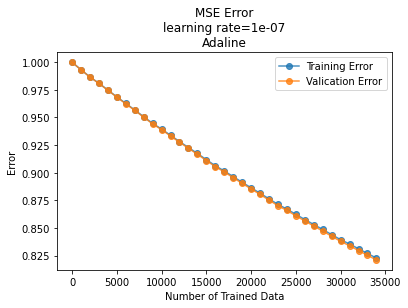

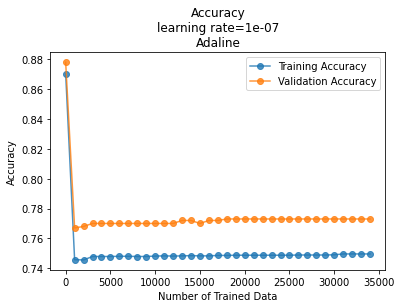

Reporting when learning rate=1e-06
Test Accuracy: 0.7745


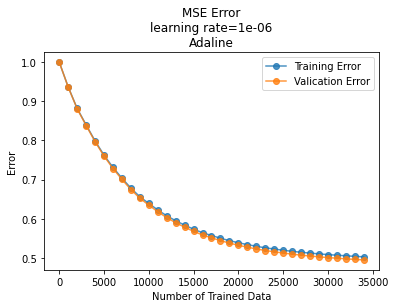

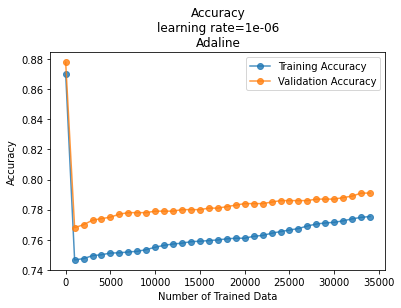

Reporting when learning rate=1e-05
Test Accuracy: 0.9735


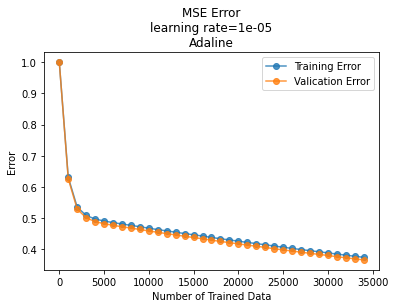

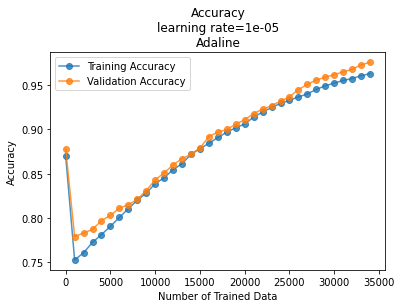

Reporting when learning rate=0.0001
Test Accuracy: 1.0


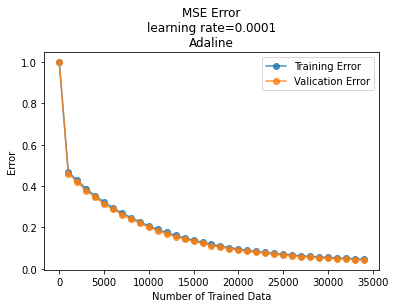

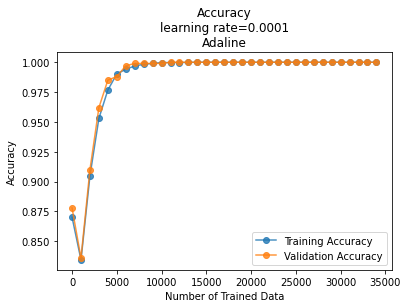

Reporting when learning rate=0.001
Test Accuracy: 1.0


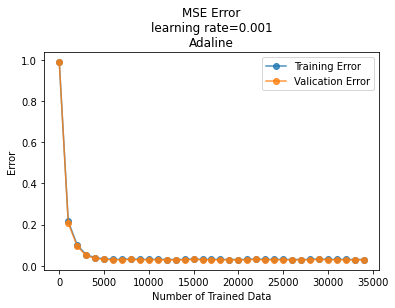

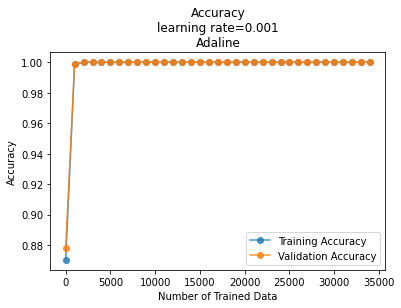

In [11]:
for lr in [0.0000001, 0.000001, 0.00001, 0.0001, 0.001]:
    adaline = Adaline(lr=lr)
    error_train, error_val, acc_train, acc_val = \
        adaline.fit(X_train, y_train, X_val, y_val, max_iter=5)
    y_pred = adaline.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when learning rate={lr}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * adaline.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nlearning rate={lr}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/adaline/lr/error_{lr}.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nlearning rate={lr}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/adaline/lr/acc_{lr}.png')
    plt.show()

Analysing impact of activation function in adaline's functionality

Reporting when activation function is identity
Test Accuracy: 1.0


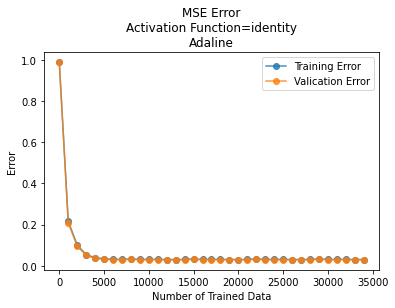

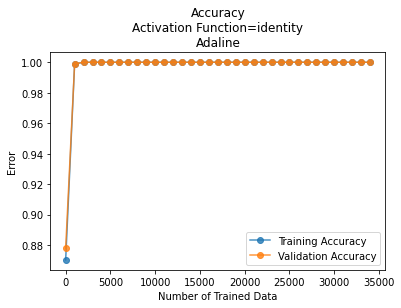

Reporting when activation function is sigmoid
Test Accuracy: 1.0


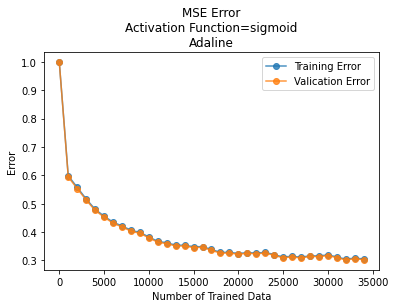

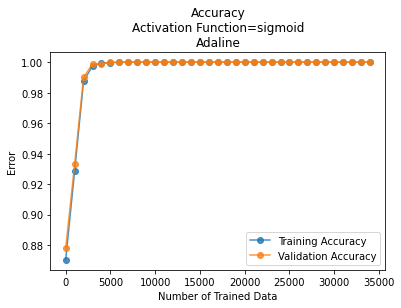

Reporting when activation function is tanh
Test Accuracy: 1.0


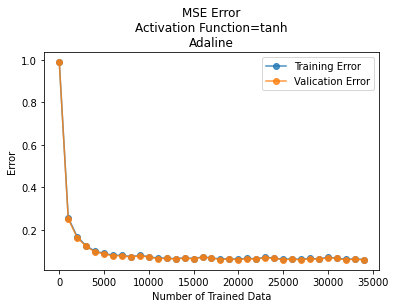

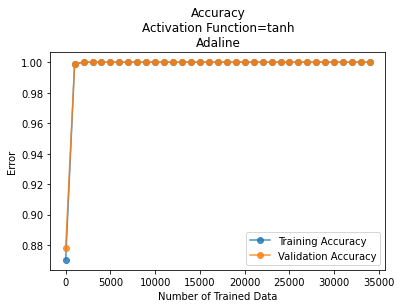

In [12]:
for act_func in ['identity', 'sigmoid', 'tanh']:
    adaline = Adaline(lr=0.001, activation_func=act_func)
    error_train, error_val, acc_train, acc_val = \
        adaline.fit(X_train, y_train, X_val, y_val, max_iter=5)
    y_pred = adaline.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when activation function is {act_func}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * adaline.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nActivation Function={act_func}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/adaline/activation_func/{act_func}_error.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nActivation Function={act_func}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/adaline/activation_func/{act_func}_acc.png')
    plt.show()

## Perceptron

Testing impact of learning rate on perceptron

Reporting when learning rate=0.001
Test Accuracy: 0.9995


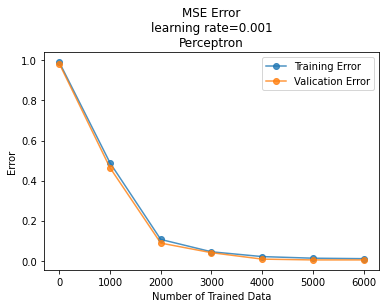

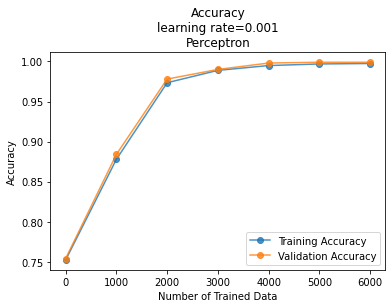

Reporting when learning rate=0.01
Test Accuracy: 1.0


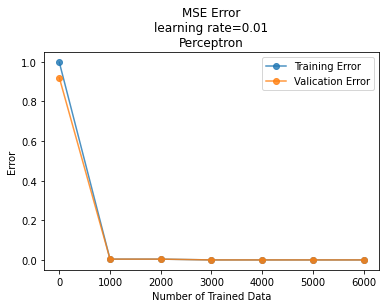

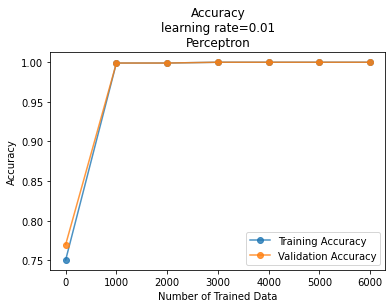

Reporting when learning rate=0.1
Test Accuracy: 1.0


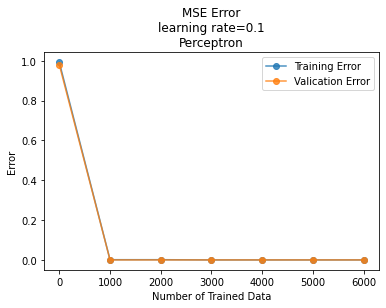

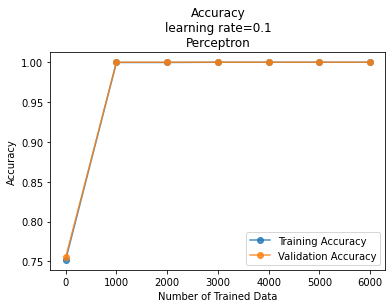

Reporting when learning rate=1
Test Accuracy: 1.0


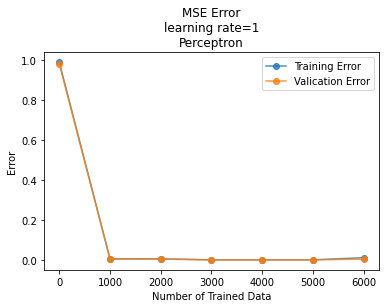

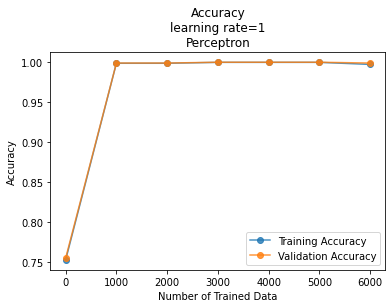

Reporting when learning rate=10
Test Accuracy: 1.0


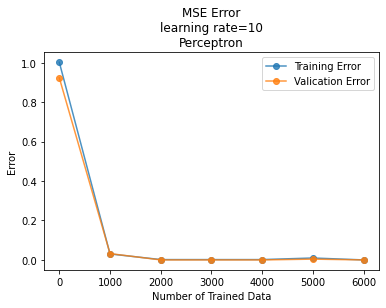

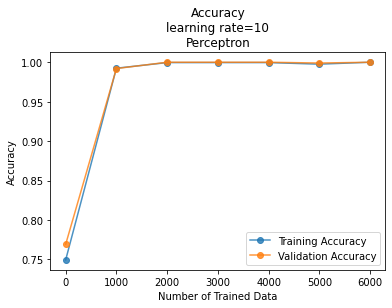

In [13]:
for lr in [0.001, 0.01, 0.1, 1, 10]:
    perceptron = Perceptron(lr=lr)
    error_train, error_val, acc_train, acc_val = \
        perceptron.fit(X_train, y_train, X_val, y_val, max_iter=1)
    y_pred = perceptron.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when learning rate={lr}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * perceptron.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nlearning rate={lr}\nPerceptron')
    plt.xlabel(f'Number of Trained Data')
    plt.ylabel(f'Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/perceptron/lr/error_{lr}.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nlearning rate={lr}\nPerceptron')
    plt.xlabel(f'Number of Trained Data')
    plt.ylabel(f'Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/perceptron/lr/acc_{lr}.png')
    plt.show()

Analysing impact of activation function in perceptron's functionality

Reporting when activation function is sign(x+(-5))
Test Accuracy: 1.0


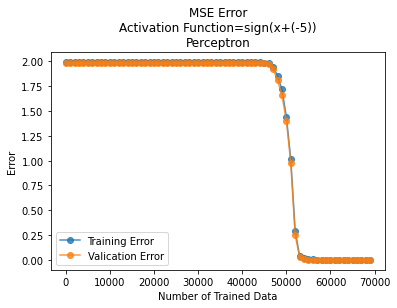

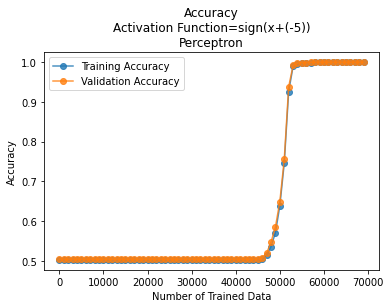

Reporting when activation function is sign(x+(0))
Test Accuracy: 0.9995


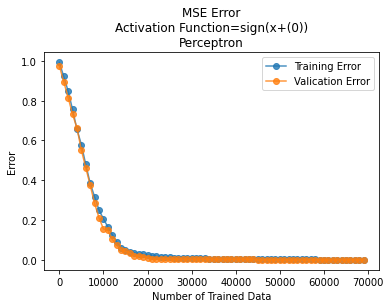

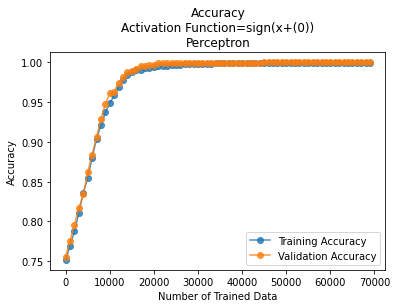

Reporting when activation function is sign(x+(5))
Test Accuracy: 1.0


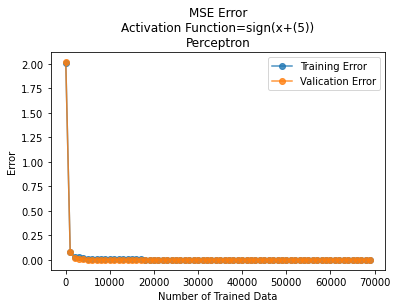

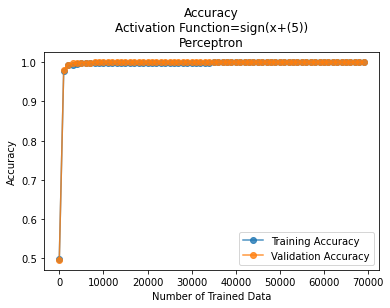

In [14]:
for act_func_offset in [-5, 0, 5]:
    perceptron = Perceptron(lr=0.0001, activation_func_offset=act_func_offset)
    error_train, error_val, acc_train, acc_val = \
        perceptron.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = perceptron.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when activation function is sign(x+({act_func_offset}))')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * perceptron.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nActivation Function=sign(x+({act_func_offset}))\nPerceptron')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/perceptron/activation_func/sign(x+({act_func_offset})_error.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nActivation Function=sign(x+({act_func_offset}))\nPerceptron')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/3/perceptron/activation_func/sign(x+({act_func_offset})_acc.png')
    plt.show()

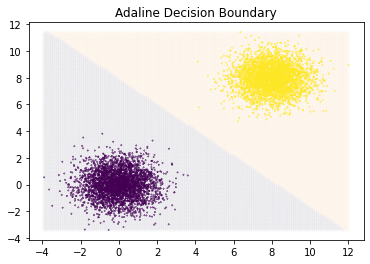

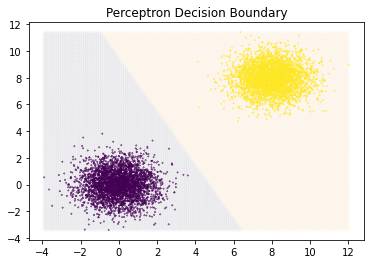

In [16]:
def draw_decision_boundary(X, y, cls, title):
    xx, yy = \
        np.mgrid[X[:,0].min():X[:,0].max():0.1, X[:,1].min():X[:,1].max():0.1]
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    y_pred_positions = cls.predict(positions)
    plt.scatter(positions[:,0], positions[:,1], c=y_pred_positions, marker='.', alpha=0.01)
    plt.scatter(X[:,0], X[:,1], c=y, marker='x', s=1, alpha=0.6)
    plt.title(title)
    plt.show()

adaline = Adaline(lr=0.001, activation_func='identity')
adaline.fit(X_train, y_train, X_val, y_val, max_iter=10)
draw_decision_boundary(X_train, y_train, adaline, title='Adaline Decision Boundary')

perceptron = Perceptron(lr=0.01)
perceptron.fit(X_train, y_train, X_val, y_val, max_iter=10)
draw_decision_boundary(X_train, y_train, perceptron, title='Perceptron Decision Boundary')

# Question 4

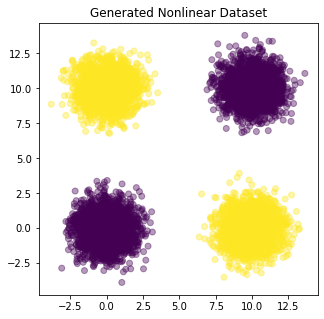

In [17]:
mean1 = np.array([10, 10])
mean2 = np.array([0, 10])
mean3 = np.array([10, 0])
mean4 = np.array([0, 0])
cov = cov1 = cov2 = np.identity(2)
dist1 = np.random.multivariate_normal(mean1, cov1, size=2500)
dist2 = np.random.multivariate_normal(mean2, cov2, size=2500)
dist3 = np.random.multivariate_normal(mean3, cov2, size=2500)
dist4 = np.random.multivariate_normal(mean4, cov2, size=2500)
X = np.concatenate((dist1, dist2, dist3, dist4), axis=0)
y = np.array([1 if (x in dist2 or x in dist3) else -1 for x in X])

fig = plt.figure(figsize=(5,5))
plt.title('Generated Nonlinear Dataset')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.4)
if SAVE_CONTENTS:
    plt.savefig('images/nonlinear_dataset.png')

In [18]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = \
     train_test_split(X_train, y_train, test_size=0.125) # 0.125 x 0.8 = 0.1

# Question 5

## Adaline

Analysing impact of learning rate in Adaline

Reporting when learning rate=1e-07
Test Accuracy: 0.374


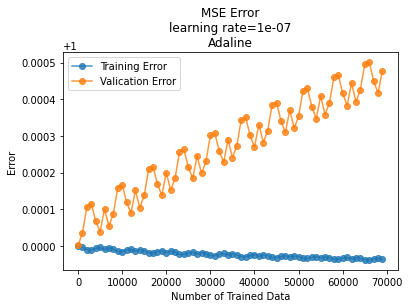

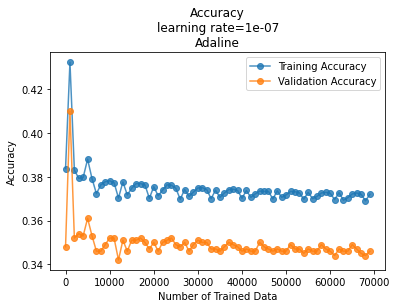

Reporting when learning rate=1e-06
Test Accuracy: 0.311


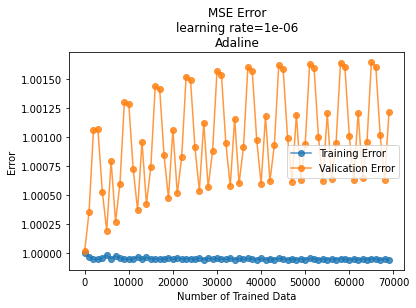

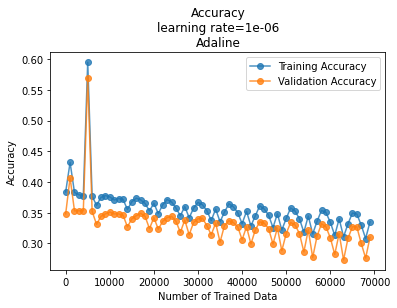

Reporting when learning rate=1e-05
Test Accuracy: 0.4985


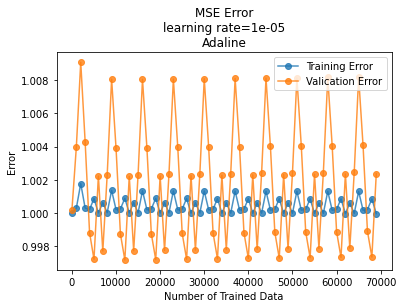

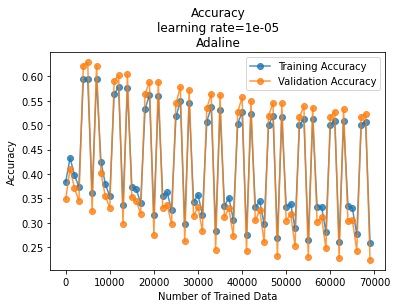

Reporting when learning rate=0.0001
Test Accuracy: 0.5015


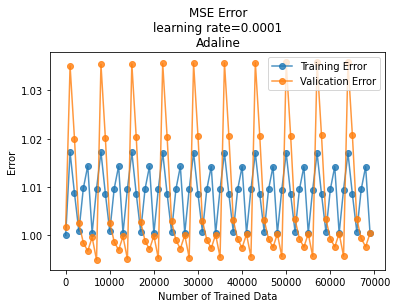

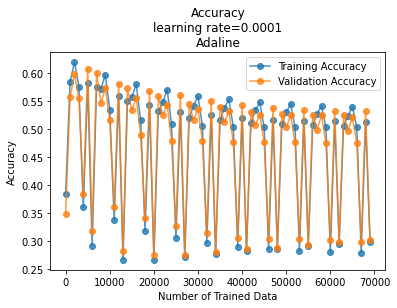

Reporting when learning rate=0.001
Test Accuracy: 0.3425


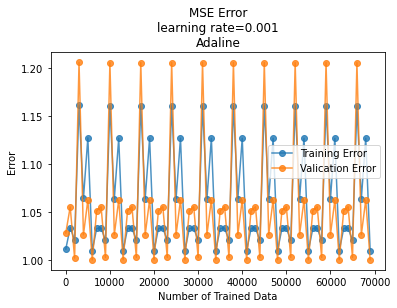

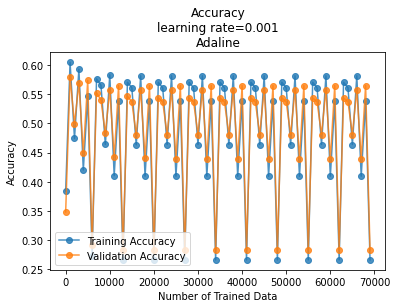

In [19]:
for lr in [0.0000001, 0.000001, 0.00001, 0.0001, 0.001]:
    adaline = Adaline(lr=lr)
    error_train, error_val, acc_train, acc_val = \
        adaline.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = adaline.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when learning rate={lr}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * adaline.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nlearning rate={lr}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/adaline/lr/error_{lr}.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nlearning rate={lr}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/adaline/lr/acc_{lr}.png')
    plt.show()

Analysing impact of activation function in Adaline

Reporting when activation function is identity
Test Accuracy: 0.3425


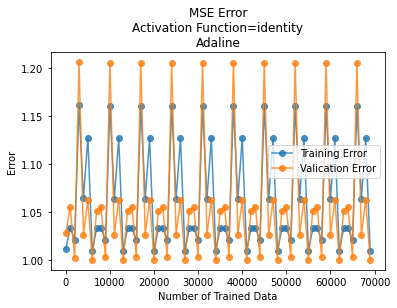

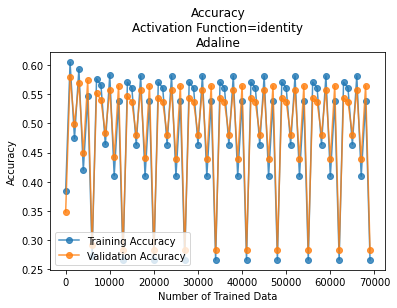

Reporting when activation function is sigmoid
Test Accuracy: 0.514


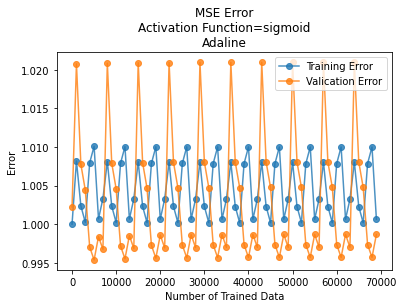

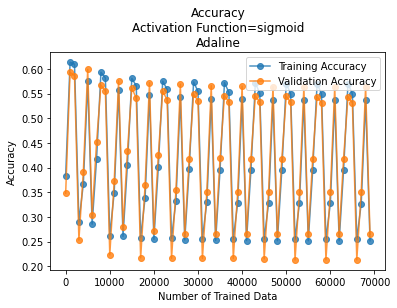

Reporting when activation function is tanh
Test Accuracy: 0.59


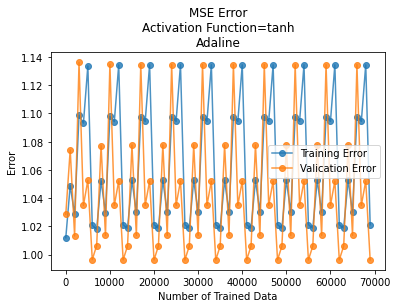

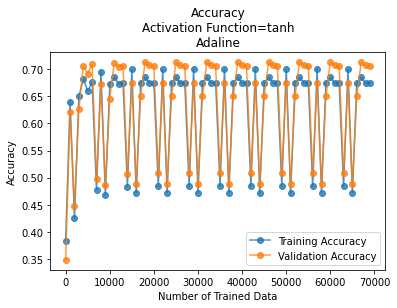

In [20]:
for act_func in ['identity', 'sigmoid', 'tanh']:
    adaline = Adaline(lr=0.001, activation_func=act_func)
    error_train, error_val, acc_train, acc_val = \
        adaline.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = adaline.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when activation function is {act_func}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * adaline.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nActivation Function={act_func}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/adaline/activation_func/{act_func}_error.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nActivation Function={act_func}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/adaline/activation_func/{act_func}_acc.png')
    plt.show()

## Perceptron

Analysing impact of learning rate in Perceptron

Reporting when learning rate=0.001
Test Accuracy: 0.5895


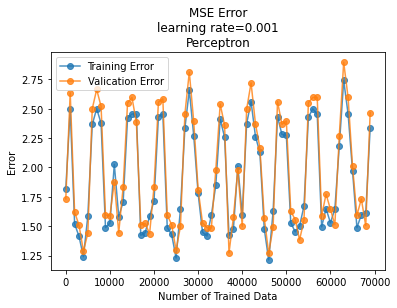

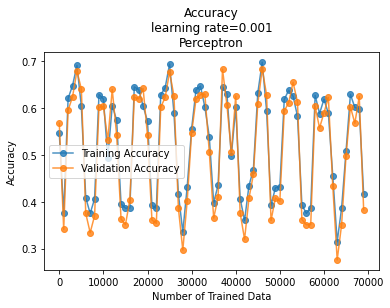

Reporting when learning rate=0.01
Test Accuracy: 0.511


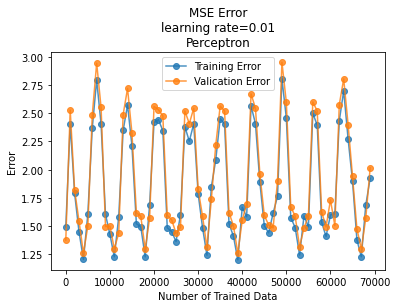

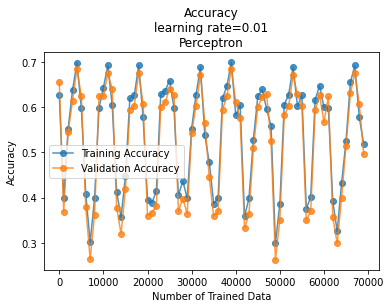

Reporting when learning rate=0.1
Test Accuracy: 0.5925


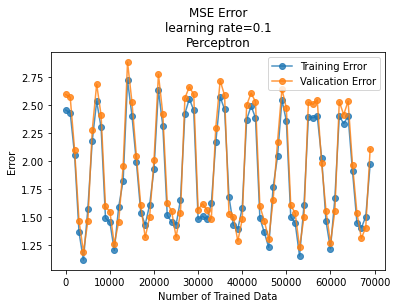

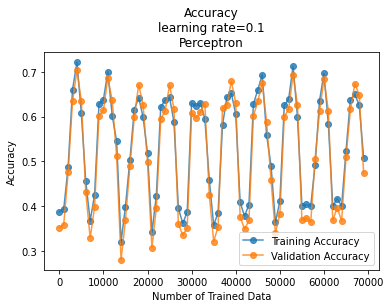

Reporting when learning rate=1
Test Accuracy: 0.604


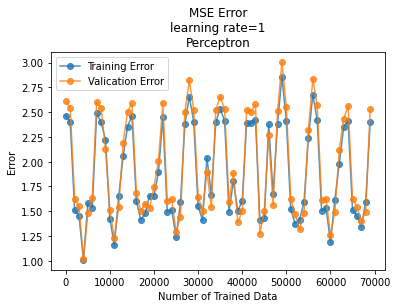

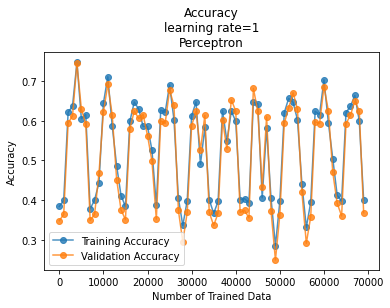

Reporting when learning rate=10
Test Accuracy: 0.5865


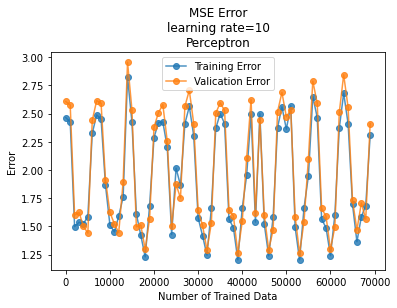

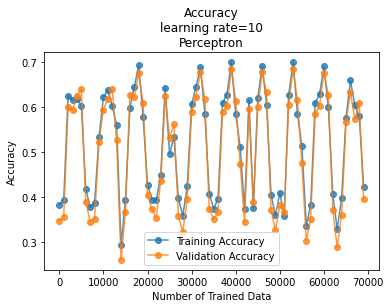

In [21]:
for lr in [0.001, 0.01, 0.1, 1, 10]:
    perceptron = Perceptron(lr=lr)
    error_train, error_val, acc_train, acc_val = \
        perceptron.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = perceptron.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when learning rate={lr}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * perceptron.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nlearning rate={lr}\nPerceptron')
    plt.xlabel(f'Number of Trained Data')
    plt.ylabel(f'Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/perceptron/lr/error_{lr}.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nlearning rate={lr}\nPerceptron')
    plt.xlabel(f'Number of Trained Data')
    plt.ylabel(f'Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/perceptron/lr/acc_{lr}.png')
    plt.show()

Analysing impact of activation function on Perceptron

Reporting when activation function is sign(x+(-5))
Test Accuracy: 0.606


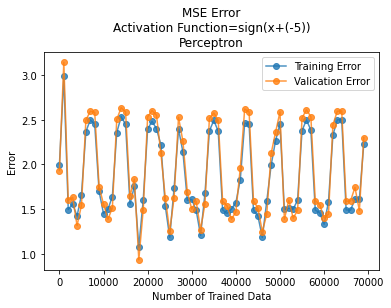

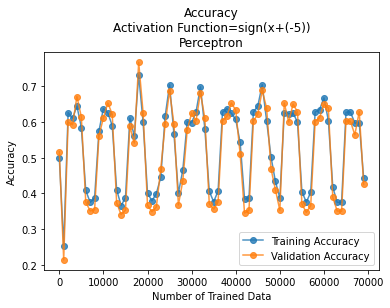

Reporting when activation function is sign(x+(0))
Test Accuracy: 0.5885


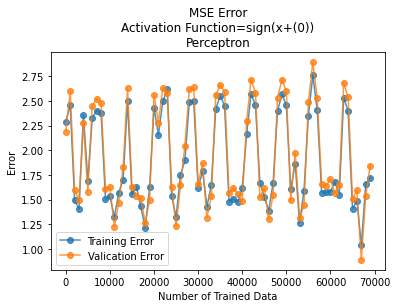

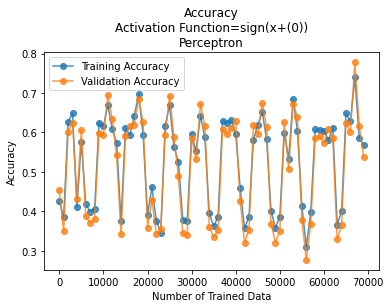

Reporting when activation function is sign(x+(5))
Test Accuracy: 0.5865


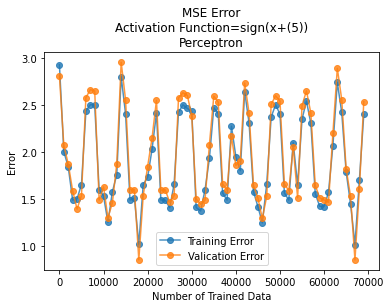

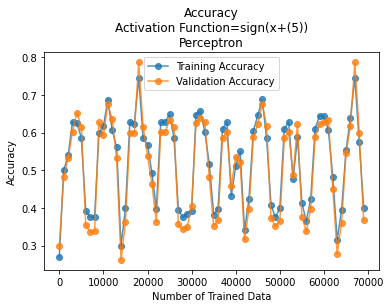

In [22]:
for act_func_offset in [-5, 0, 5]:
    perceptron = Perceptron(lr=0.01, activation_func_offset=act_func_offset)
    error_train, error_val, acc_train, acc_val = \
        perceptron.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = perceptron.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when activation function is sign(x+({act_func_offset}))')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * perceptron.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.title(f'MSE Error\nActivation Function=sign(x+({act_func_offset}))\nPerceptron')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/perceptron/activation_func/sign(x+({act_func_offset})_error.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nActivation Function=sign(x+({act_func_offset}))\nPerceptron')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/5/perceptron/activation_func/sign(x+({act_func_offset})_acc.png')
    plt.show()

# Question 6

## Adaline

Analysing impact of learning rate in Adaline

Reporting when learning rate=1e-09
Test Accuracy: 0.828


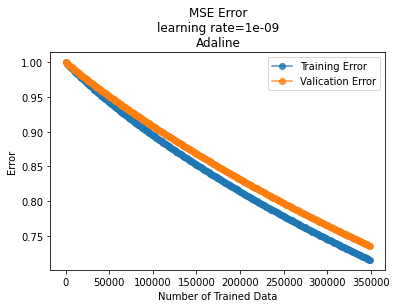

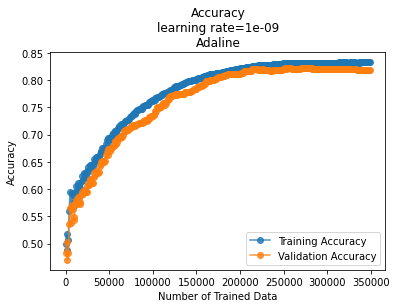

Reporting when learning rate=1e-08
Test Accuracy: 0.8295


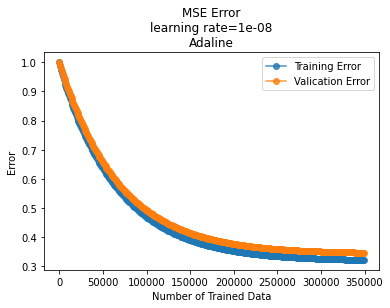

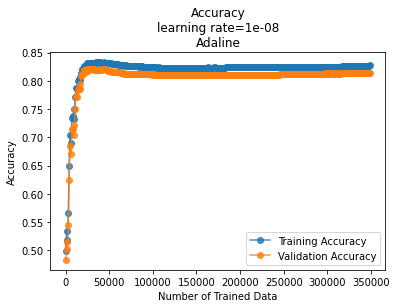

Reporting when learning rate=1e-07
Test Accuracy: 0.8715


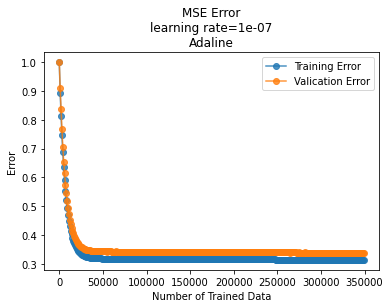

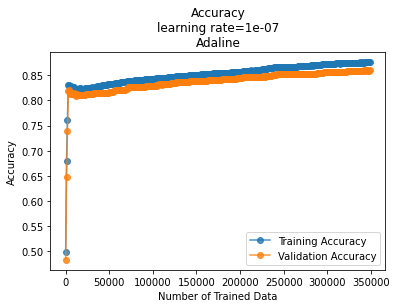

Reporting when learning rate=1e-06
Test Accuracy: 0.972


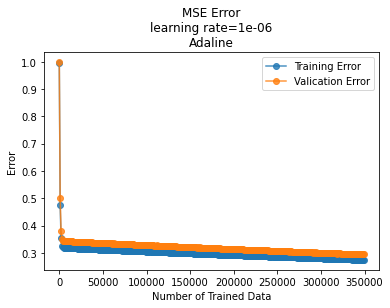

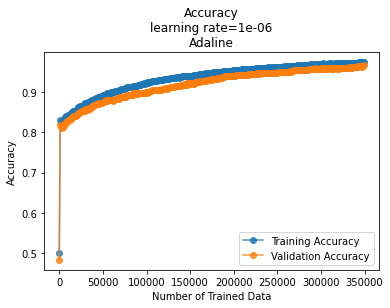

Reporting when learning rate=1e-05
Test Accuracy: 1.0


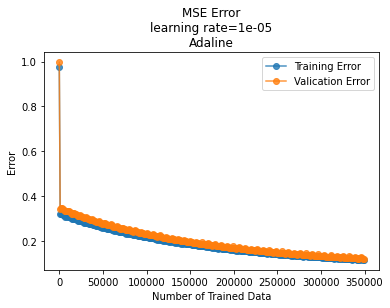

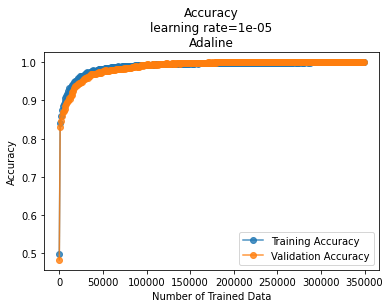

In [24]:
for lr in [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001]:
    adaline = Adaline(lr=lr, degree=2)
    error_train, error_val, acc_train, acc_val = \
        adaline.fit(X_train, y_train, X_val, y_val, max_iter=50)
    y_pred = adaline.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when learning rate={lr}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * adaline.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nlearning rate={lr}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/adaline/lr/error_{lr}.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nlearning rate={lr}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/adaline/lr/acc_{lr}.png')
    plt.show()

Analysing impact of activation function in Adaline

Reporting when activation function is identity
Test Accuracy: 1.0


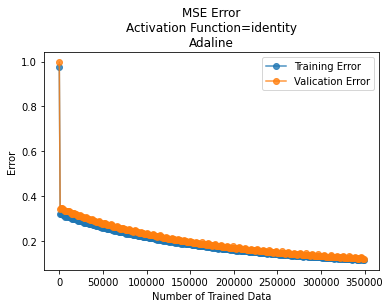

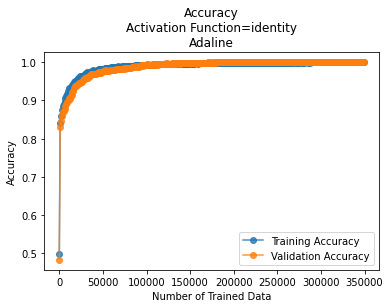

Reporting when activation function is sigmoid
Test Accuracy: 0.9955


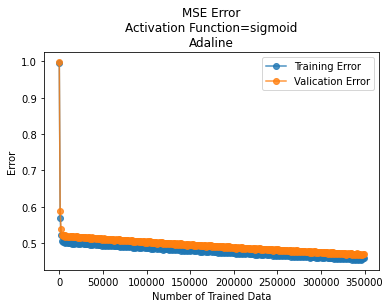

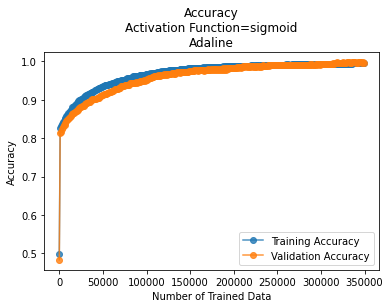

Reporting when activation function is tanh
Test Accuracy: 1.0


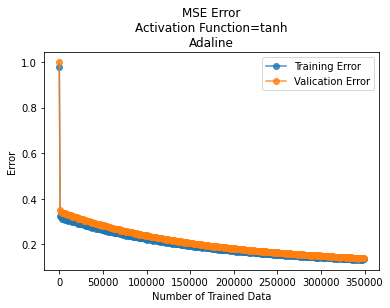

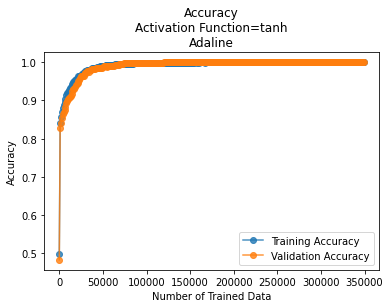

In [26]:
for act_func in ['identity', 'sigmoid', 'tanh']:
    adaline = Adaline(lr=0.00001, activation_func=act_func, degree=2)
    error_train, error_val, acc_train, acc_val = \
        adaline.fit(X_train, y_train, X_val, y_val, max_iter=50)
    y_pred = adaline.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when activation function is {act_func}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * adaline.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nActivation Function={act_func}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/adaline/activation_func/{act_func}_error.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nActivation Function={act_func}\nAdaline')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/adaline/activation_func/{act_func}_acc.png')
    plt.show()

## Perceptron

Analysing impact of learning rate in Perceptron

Reporting when learning rate=0.001
Test Accuracy: 0.9975


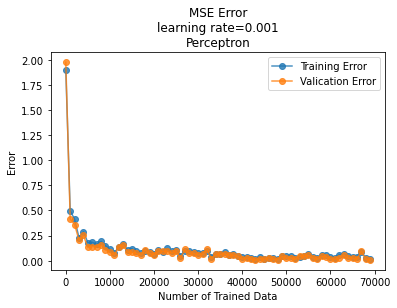

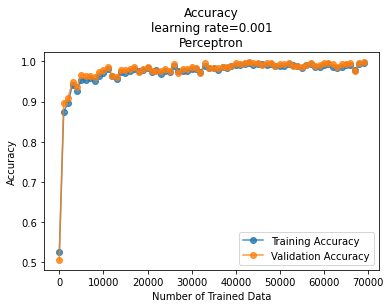

Reporting when learning rate=0.01
Test Accuracy: 0.9955


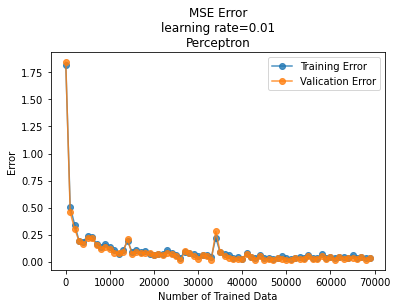

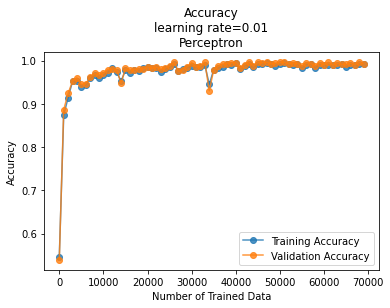

Reporting when learning rate=0.1
Test Accuracy: 0.996


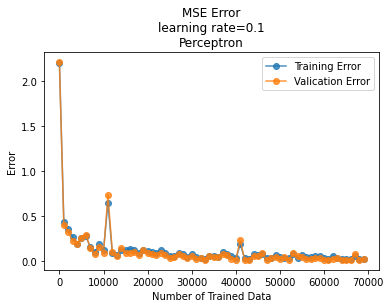

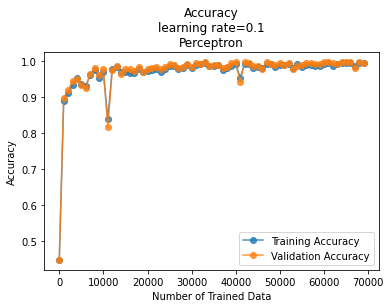

Reporting when learning rate=1
Test Accuracy: 0.9965


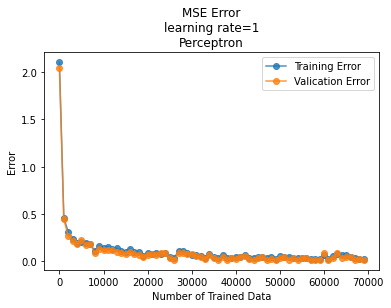

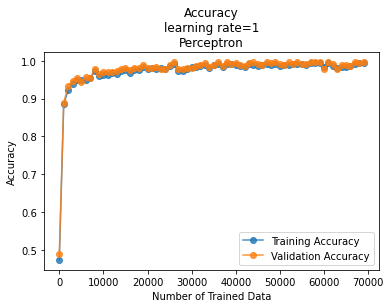

Reporting when learning rate=10
Test Accuracy: 0.9875


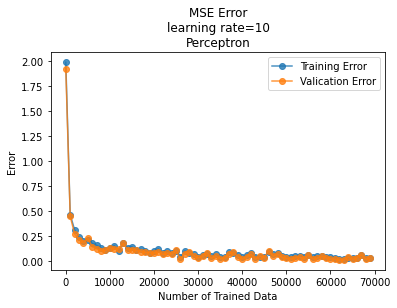

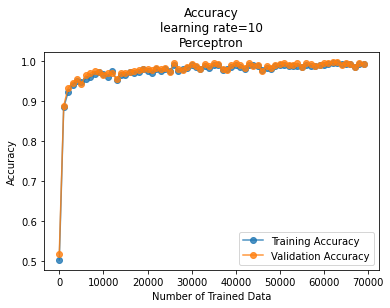

In [42]:
for lr in [0.001, 0.01, 0.1, 1, 10]:
    perceptron = Perceptron(lr=lr, degree=2)
    error_train, error_val, acc_train, acc_val = \
        perceptron.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = perceptron.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when learning rate={lr}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * perceptron.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.title(f'MSE Error\nlearning rate={lr}\nPerceptron')
    plt.xlabel(f'Number of Trained Data')
    plt.ylabel(f'Error')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/perceptron/lr/error_{lr}.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nlearning rate={lr}\nPerceptron')
    plt.xlabel(f'Number of Trained Data')
    plt.ylabel(f'Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/perceptron/lr/acc_{lr}.png')
    plt.show()

Analysing impact of activation function on Perceptron

Reporting when activation function is sign(x+(-5))
Test Accuracy: 0.9805


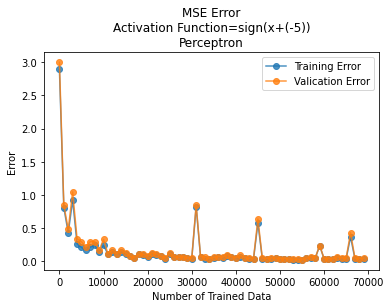

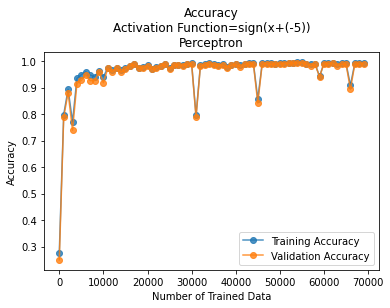

Reporting when activation function is sign(x+(0))
Test Accuracy: 0.9895


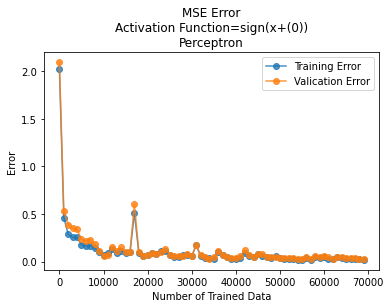

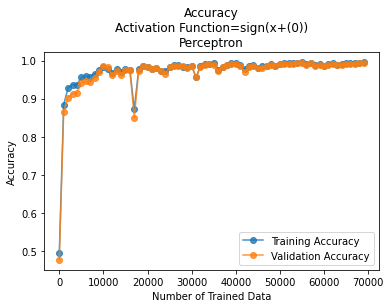

Reporting when activation function is sign(x+(5))
Test Accuracy: 0.984


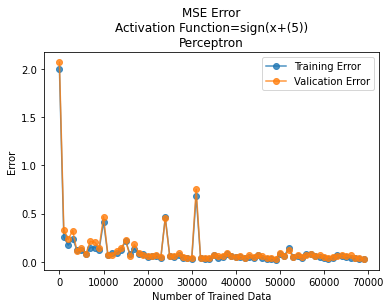

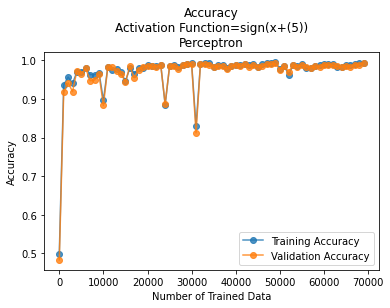

In [32]:
for act_func_offset in [-5, 0, 5]:
    perceptron = Perceptron(lr=0.01, degree=2, activation_func_offset=act_func_offset)
    error_train, error_val, acc_train, acc_val = \
        perceptron.fit(X_train, y_train, X_val, y_val, max_iter=10)
    y_pred = perceptron.predict(X_test)
    accuracy_score(y_test, y_pred)
    print(f'Reporting when activation function is sign(x+({act_func_offset}))')
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    iteration = np.array(range(len(error_train))) * perceptron.update_statistics_step
    plt.plot(iteration, error_train, marker='o', alpha=0.8, label='Training Error')
    plt.plot(iteration, error_val, marker='o', alpha=0.8, label='Valication Error')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Error')
    plt.title(f'MSE Error\nActivation Function=sign(x+({act_func_offset}))\nPerceptron')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/perceptron/activation_func/sign(x+({act_func_offset})_error.png')
    plt.show()
    plt.plot(iteration, acc_train, marker='o', alpha=0.8, label=f'Training Accuracy')
    plt.plot(iteration, acc_val, marker='o', alpha=0.8, label=f'Validation Accuracy')
    plt.title(f'Accuracy\nActivation Function=sign(x+({act_func_offset}))\nPerceptron')
    plt.xlabel('Number of Trained Data')
    plt.ylabel('Accuracy')
    plt.legend()
    if SAVE_CONTENTS:
        plt.savefig(f'images/6/perceptron/activation_func/sign(x+({act_func_offset})_acc.png')
    plt.show()

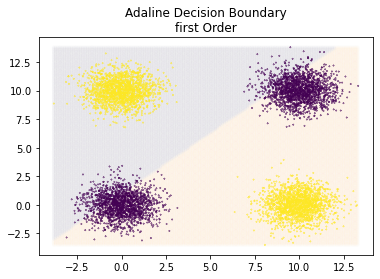

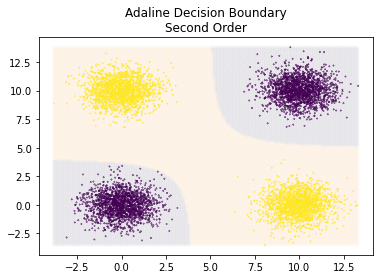

In [34]:
adaline = Adaline(lr=0.001, activation_func='identity')
adaline.fit(X_train, y_train, X_val, y_val, max_iter=50)
draw_decision_boundary(X_train, y_train, adaline, title='Adaline Decision Boundary\nfirst Order')

adaline = Adaline(lr=0.00001, activation_func='identity', degree=2)
adaline.fit(X_train, y_train, X_val, y_val, max_iter=50)
draw_decision_boundary(X_train, y_train, adaline, title='Adaline Decision Boundary\nSecond Order')

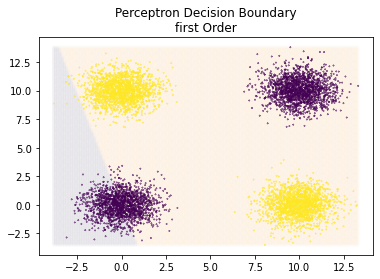

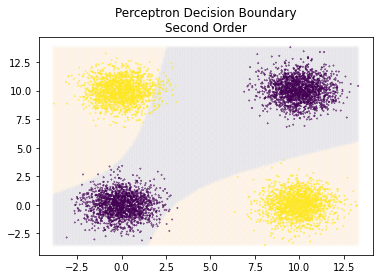

In [35]:
perceptron = Perceptron(lr=0.001)
perceptron.fit(X_train, y_train, X_val, y_val, max_iter=50)
draw_decision_boundary(X_train, y_train, perceptron, title='Perceptron Decision Boundary\nfirst Order')

perceptron = Perceptron(lr=0.001, degree=2)
perceptron.fit(X_train, y_train, X_val, y_val, max_iter=50)
draw_decision_boundary(X_train, y_train, perceptron, title='Perceptron Decision Boundary\nSecond Order')

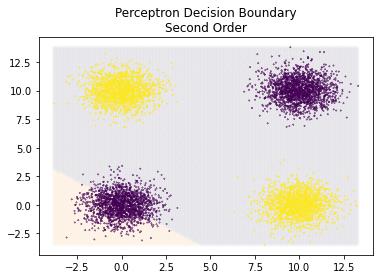

In [37]:
draw_decision_boundary(X_train, y_train, adaline, title='Perceptron Decision Boundary\nSecond Order')